In [3]:
try: # if in google colab, download necessary python files
  import google.colab
  ! git clone https://github.com/pesvut/opt-tools.git && mv ./opt-tools/src/*.py .
except ModuleNotFoundError:
  pass
! pip install -qq transformers datasets evaluate zstandard welford einops

In [4]:
from model import Model
from texts import prepare_pile, prepare_code
import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from welford import Welford
import einops

In [5]:
def prepare( dataset_name ):
    if dataset_name == 'pile':
        return prepare_pile()
    if dataset_name == 'code':
        return prepare_code()

opt = Model("125m")

- Loaded OPT-125m
 - Registered 12 OPT Attention Layers


In [7]:
print( opt.d_model, len(opt.model.decoder.layers) )

768 12


In [ ]:
def get_activation_means( dataset_name, limit=1000, sample_size=10000, num_samples=1, 
                check_accuracy=False, k=10, check_skips=False ):
    dataset, label, skip_eval = prepare( dataset_name )
    #counters = []
    counter = None
    curr_count = 0
    with tqdm(total=sample_size*num_samples) as pbar:
      with torch.no_grad():
        for data in dataset:
            text = data[label]
            input_ids = opt.get_ids( text, limit=limit )
            text_activations = opt.get_text_activations( input_ids=input_ids )
            #print([ np.array( x.size() ) for x in text_activations ])
            ids = input_ids.squeeze().detach().cpu()

            # Criteria for counting the token activation
            criteria = torch.ones_like( ids, dtype=torch.bool )

            # check if prediction is accurate enough to count
            if check_accuracy:
                residual_stream = opt.get_residual_stream( text_activations=text_activations )
                logits = opt.unembed( residual_stream[-1] ).detach().cpu()
                top_k_tokens = opt.top_k_tokens( logits, k=k ).squeeze()

                for index in range(len(ids)-1):
                    criteria[index] *= (ids[index+1] in top_k_tokens[index])

            # Choose a set of token ids to skip 
            if check_skips:
                skip_ids = set()
                for skip_string in skip_eval:
                    skip_id = int( opt.get_ids( skip_string ).squeeze()[-1] )
                    skip_ids.add( skip_id )

                for index in range(len(ids)-1):
                    criteria[index] *= (ids[index+1] in skip_ids)
                
            num_valid_tokens = criteria.sum()
            curr_count += num_valid_tokens

            attn_pre_out = opt.get_attn_pre_out_activations(
                text_activations=text_activations, reshape=True )
            attn_pre_out = attn_pre_out.detach().cpu()

            if counter is None:
                counter = [ [] for layer in range(len(attn_pre_out))  ]

            for layer_index, layer in enumerate(attn_pre_out):
                for token_index, activation in enumerate(layer):
                    if not criteria[token_index]:
                        continue
                    counter[layer_index].append( activation )

            pbar.update( int(num_valid_tokens) )

            if curr_count > sample_size:
                break
    
    return torch.stack([ torch.stack(x) for x in counter ])

No config specified, defaulting to: the_pile/all


  0%|          | 0/10000.0 [00:00<?, ?it/s]

torch.Size([12, 10013, 12, 64])


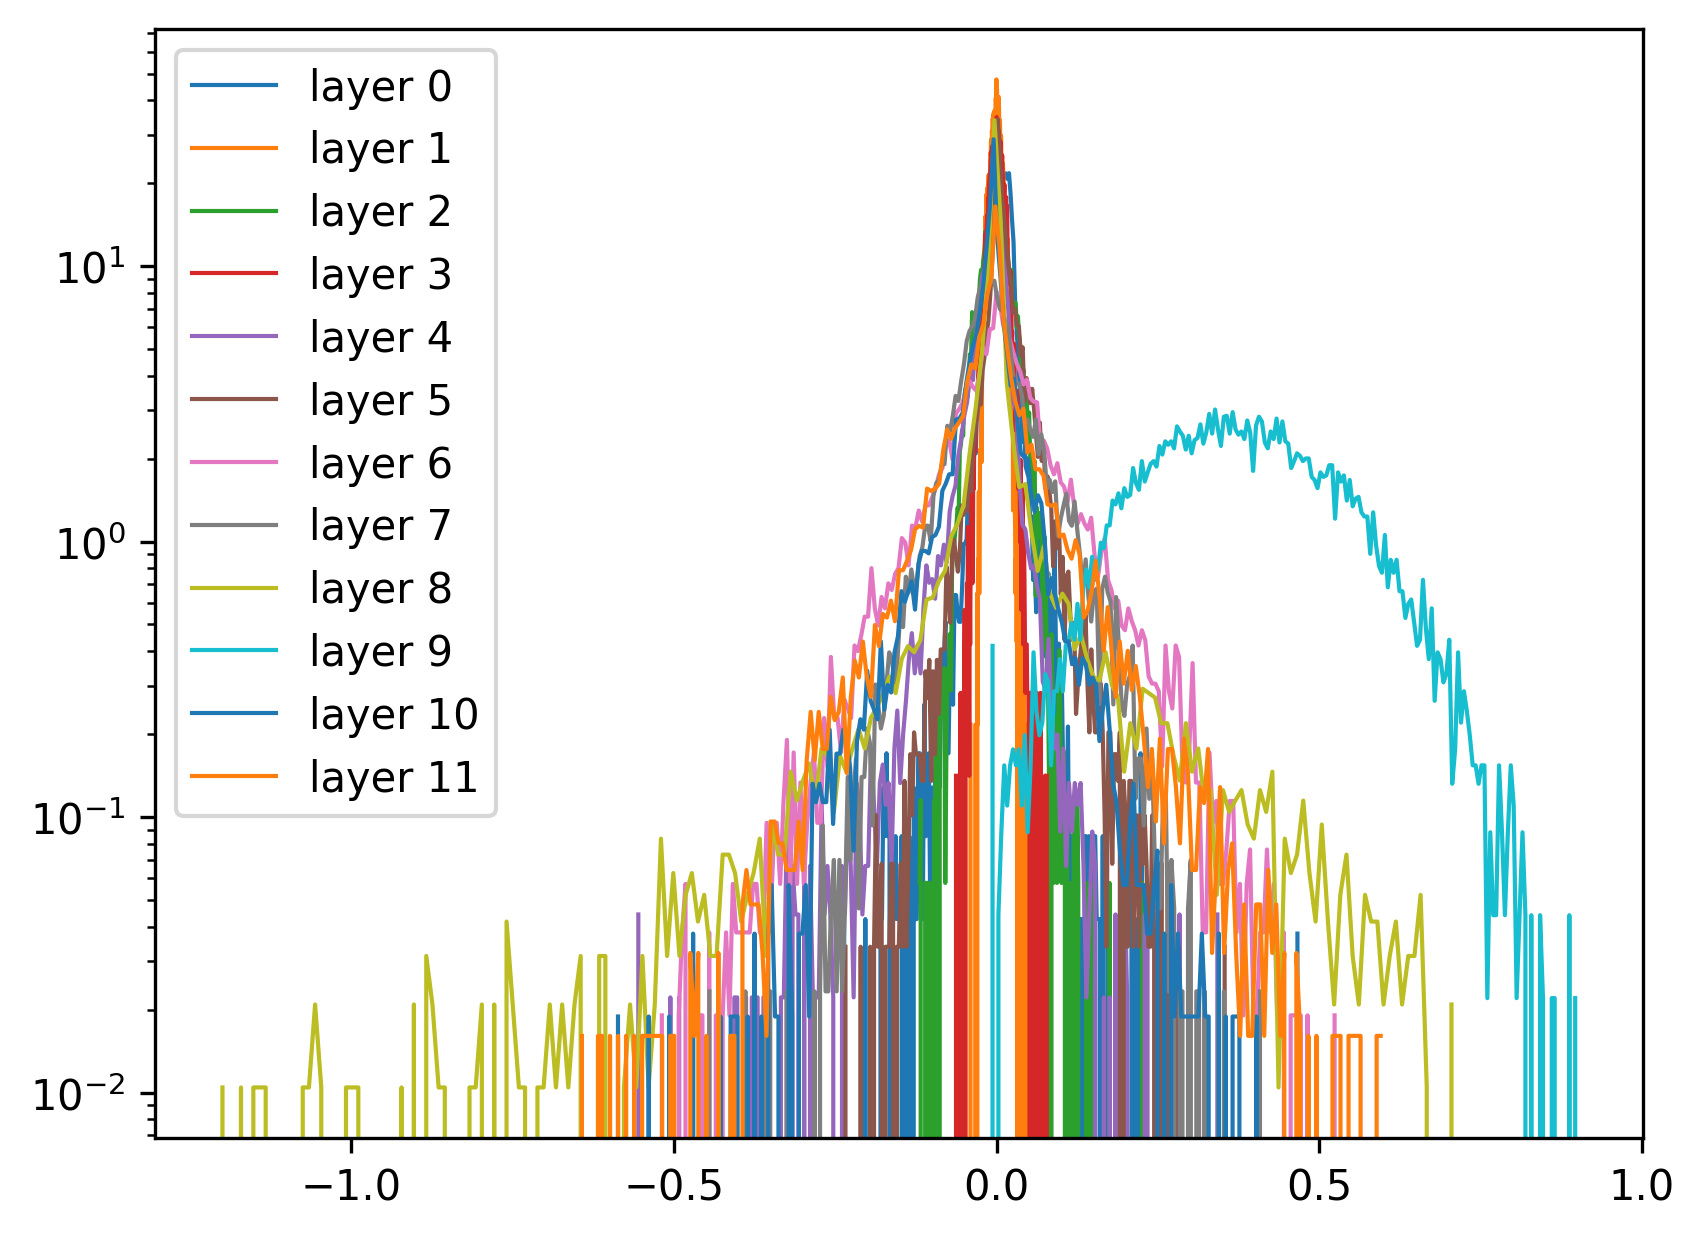

Using custom data configuration codeparrot--codeparrot-clean-valid-826c6fd8b27e5523
Found cached dataset json (/config/.cache/huggingface/datasets/codeparrot___json/codeparrot--codeparrot-clean-valid-826c6fd8b27e5523/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10000.0 [00:00<?, ?it/s]

torch.Size([12, 10503, 12, 64])


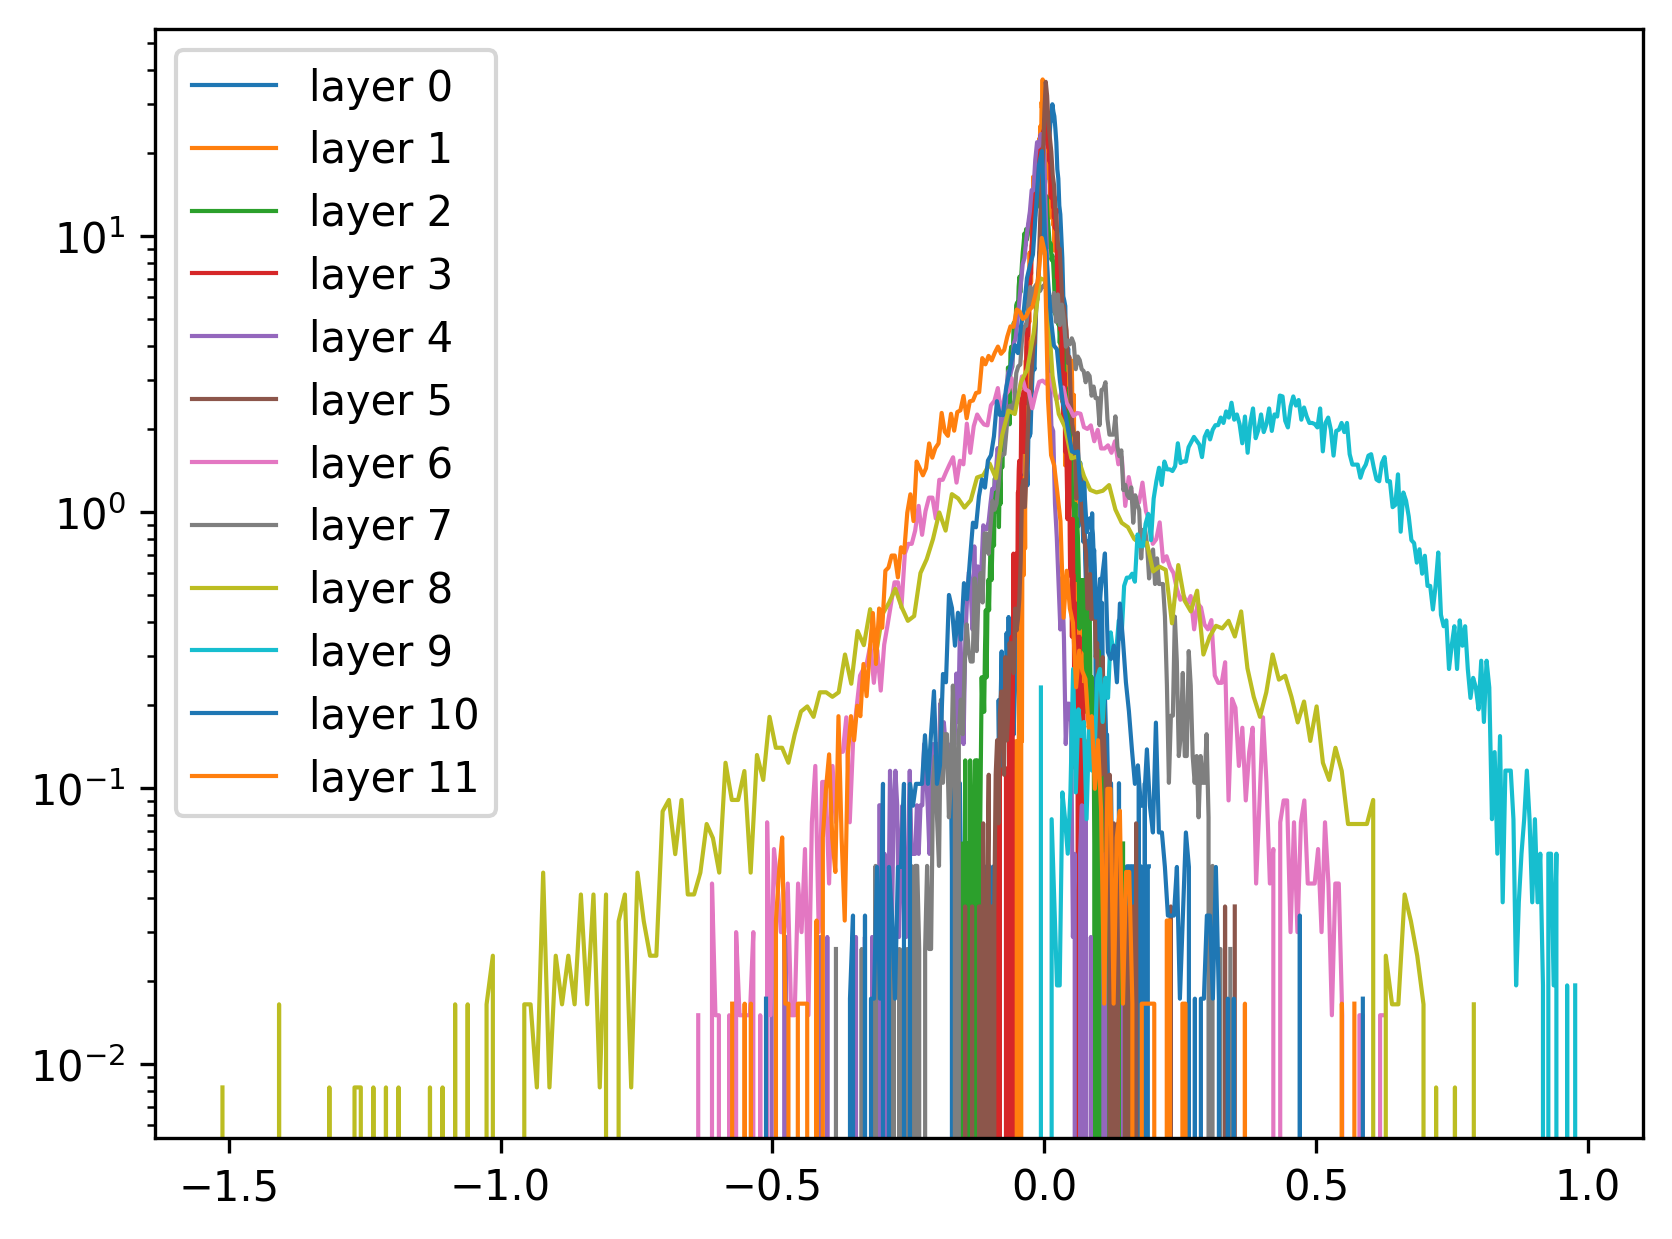

In [ ]:
from matplotlib import pyplot as plt

def running_mean(x, N):
    x_mean = pd.Series(x).rolling(window=N, min_periods=1).mean().to_numpy()
    return x_mean

def plot_head_activations(dataset):
    counters = get_activation_means(dataset, sample_size=1e4)
    print( counters.size() )

    plt.figure()
    for layer in range(12):
        #print( counters.transpose(1, -1).size())
        hist, bin_edges = np.histogram(counters.transpose(1, 2).transpose(2,3)[layer][0][49], bins=200, density=True )
        smooth_hist = running_mean( hist, 1 )
        medians = running_mean( bin_edges, 2 )[1:]
        plt.semilogy( medians, smooth_hist, label=f'layer {layer}', linewidth=1 )
    plt.legend()
    plt.show()


plot_head_activations('pile')
plot_head_activations('code')


In [ ]:
def calculate_mass( dataset ):
    counters = get_activation_means(dataset, sample_size=1e4)
    print(counters.size())
    num_tokens = counters.size()[1]

    pos_mass = np.einsum( 'lihp,lihp -> lhp', counters, counters>0 )/num_tokens
    neg_mass = np.einsum( 'lihp,lihp -> lhp', counters, counters<0 )/num_tokens

    return pos_mass, neg_mass

pile_pos, pile_neg = calculate_mass( 'pile' )
code_pos, code_neg = calculate_mass( 'code' )

No config specified, defaulting to: the_pile/all


  0%|          | 0/10000.0 [00:00<?, ?it/s]

torch.Size([12, 10013, 12, 64])


Using custom data configuration codeparrot--codeparrot-clean-valid-826c6fd8b27e5523
Found cached dataset json (/config/.cache/huggingface/datasets/codeparrot___json/codeparrot--codeparrot-clean-valid-826c6fd8b27e5523/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10000.0 [00:00<?, ?it/s]

torch.Size([12, 10503, 12, 64])


In [ ]:
for layer in range(12):
    break
    head = 0
    plt.figure()
    plt.title(f'Layer {layer} Head {head}')
    plt.semilogy( np.abs(pile_neg[layer][head]), base=2 )
    plt.semilogy( pile_pos[layer][head], base=2 )
    plt.semilogy( np.abs(code_neg[layer][head]), ':', base=2)
    plt.semilogy( code_pos[layer][head], ':', base=2)
    plt.show()

[False, False, False, False, False, False, False, False, False, False, False, False]


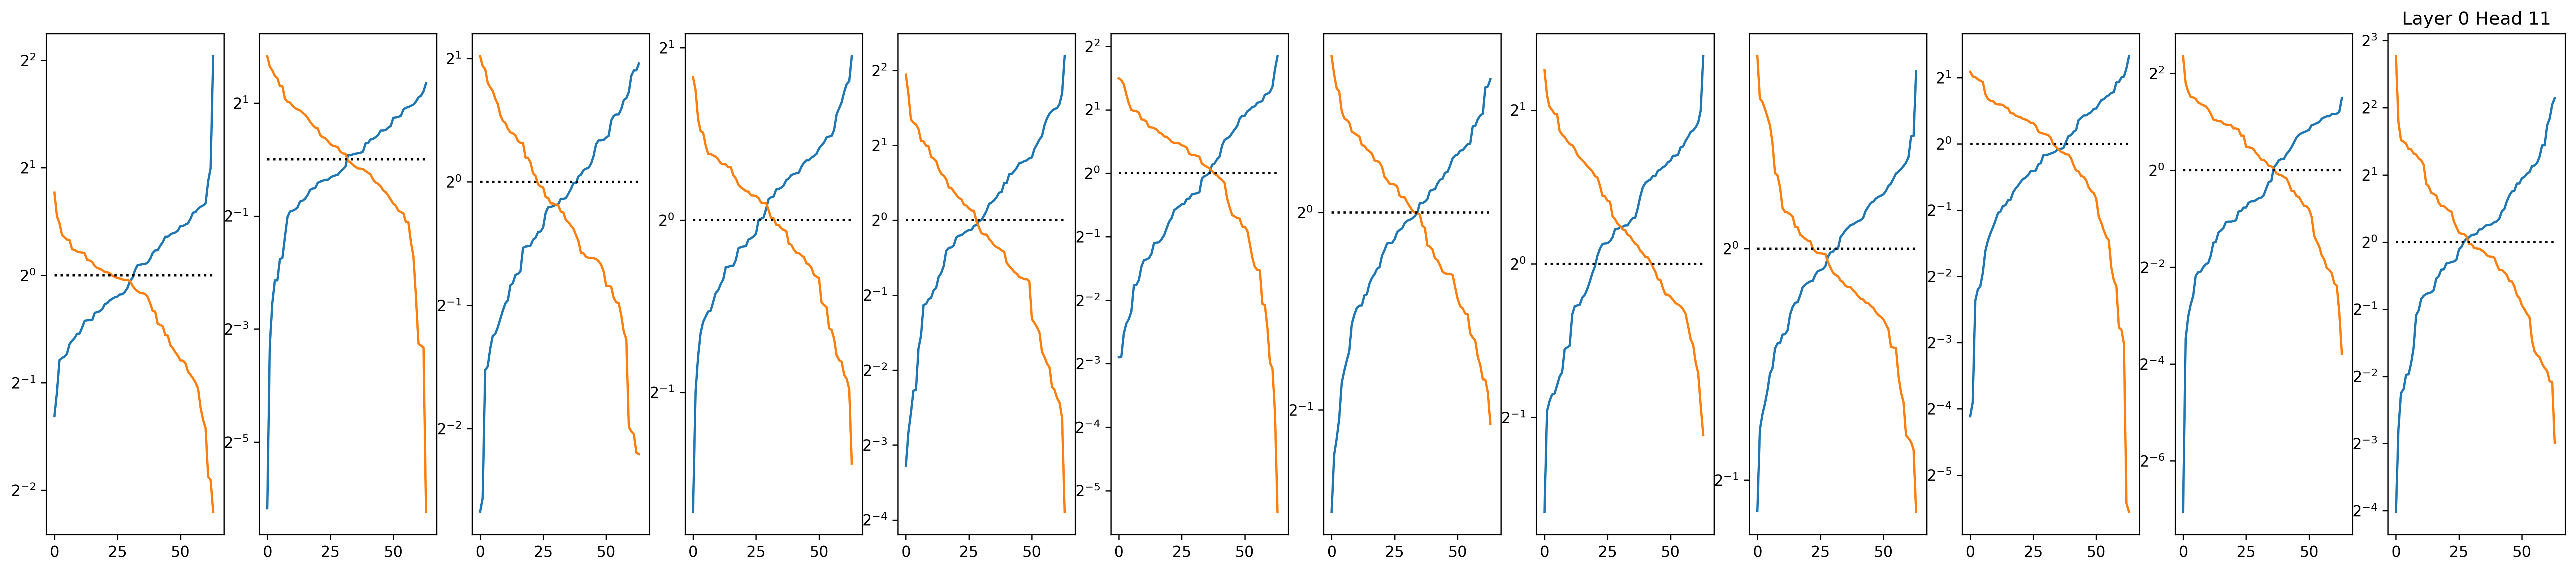

[False, False, False, False, False, False, False, False, False, False, False, False]


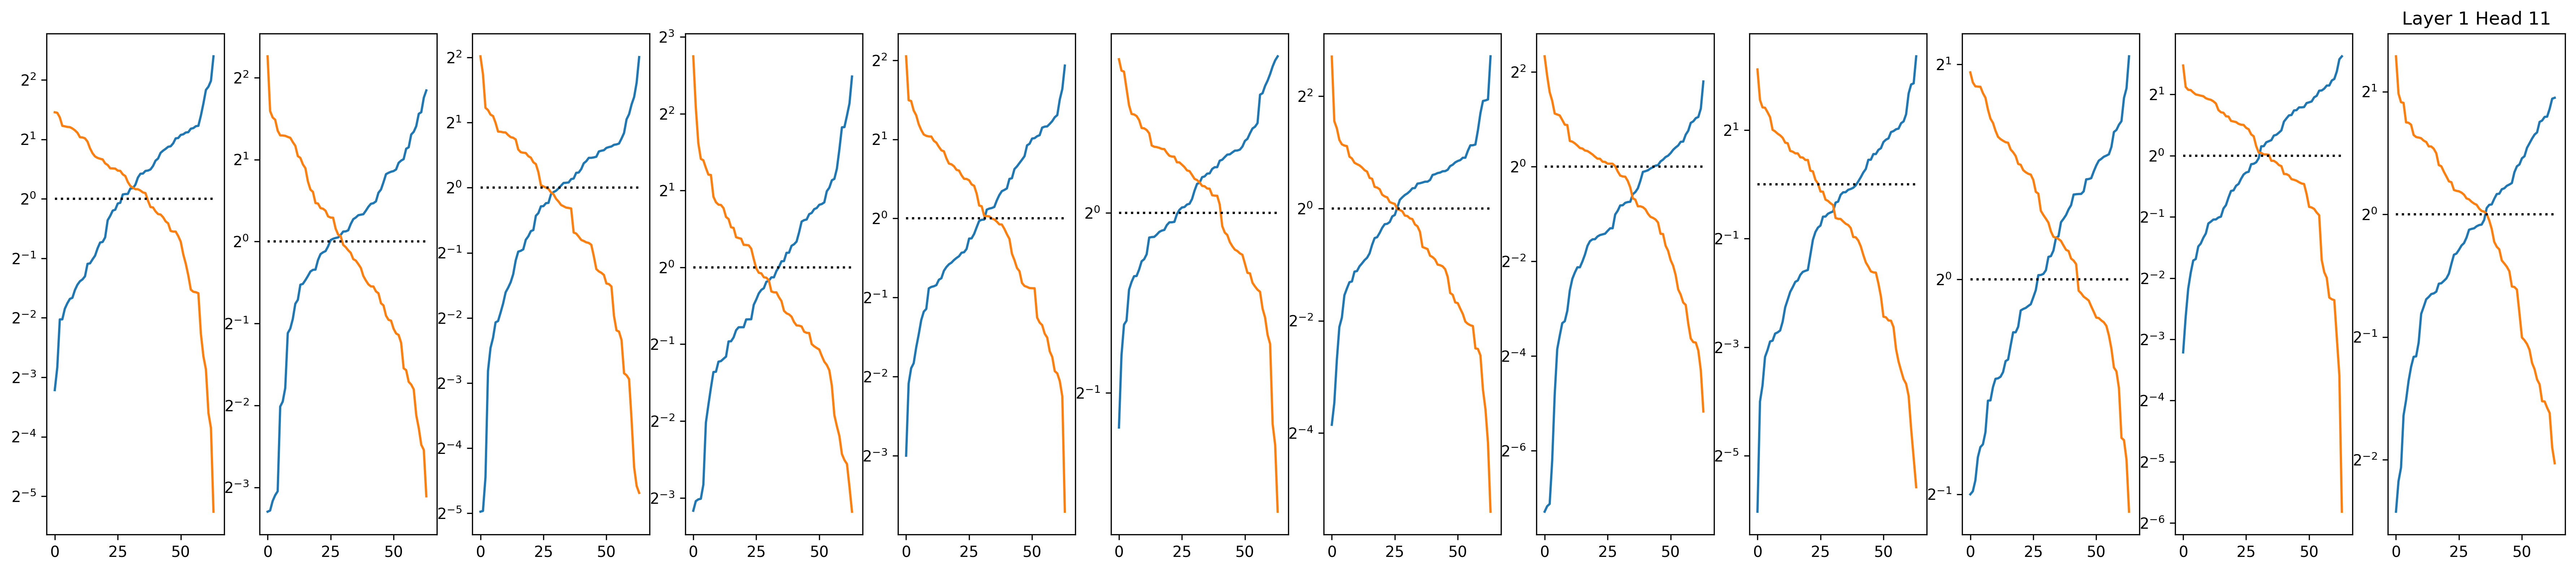

[False, True, True, False, False, False, False, False, False, False, False, False]


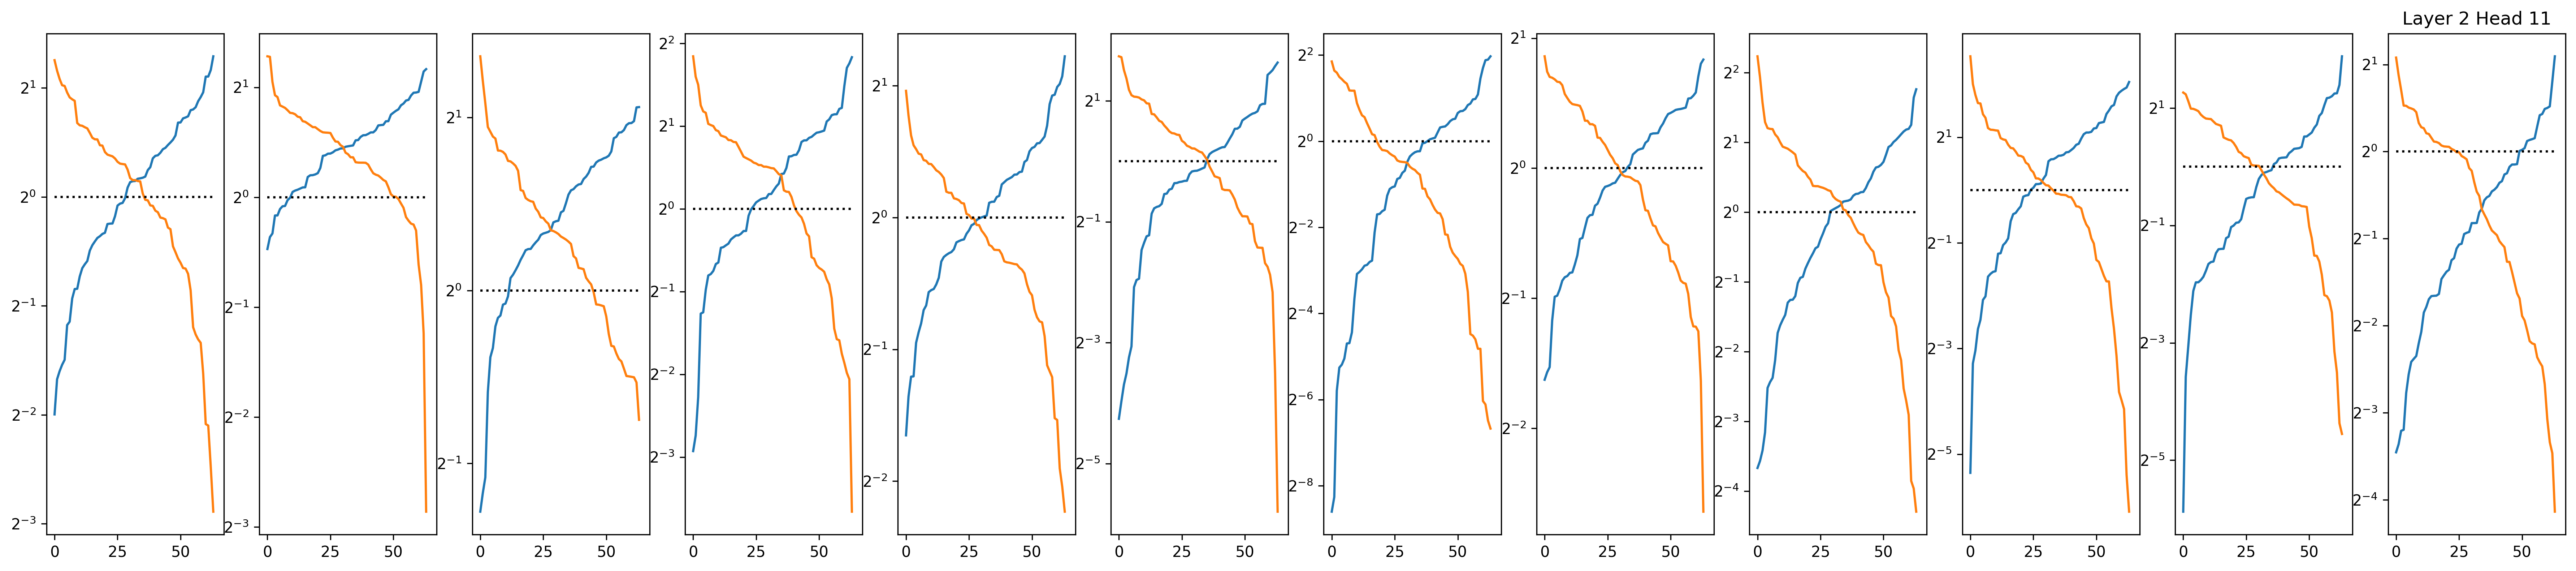

[False, False, False, False, False, False, False, False, False, True, False, False]


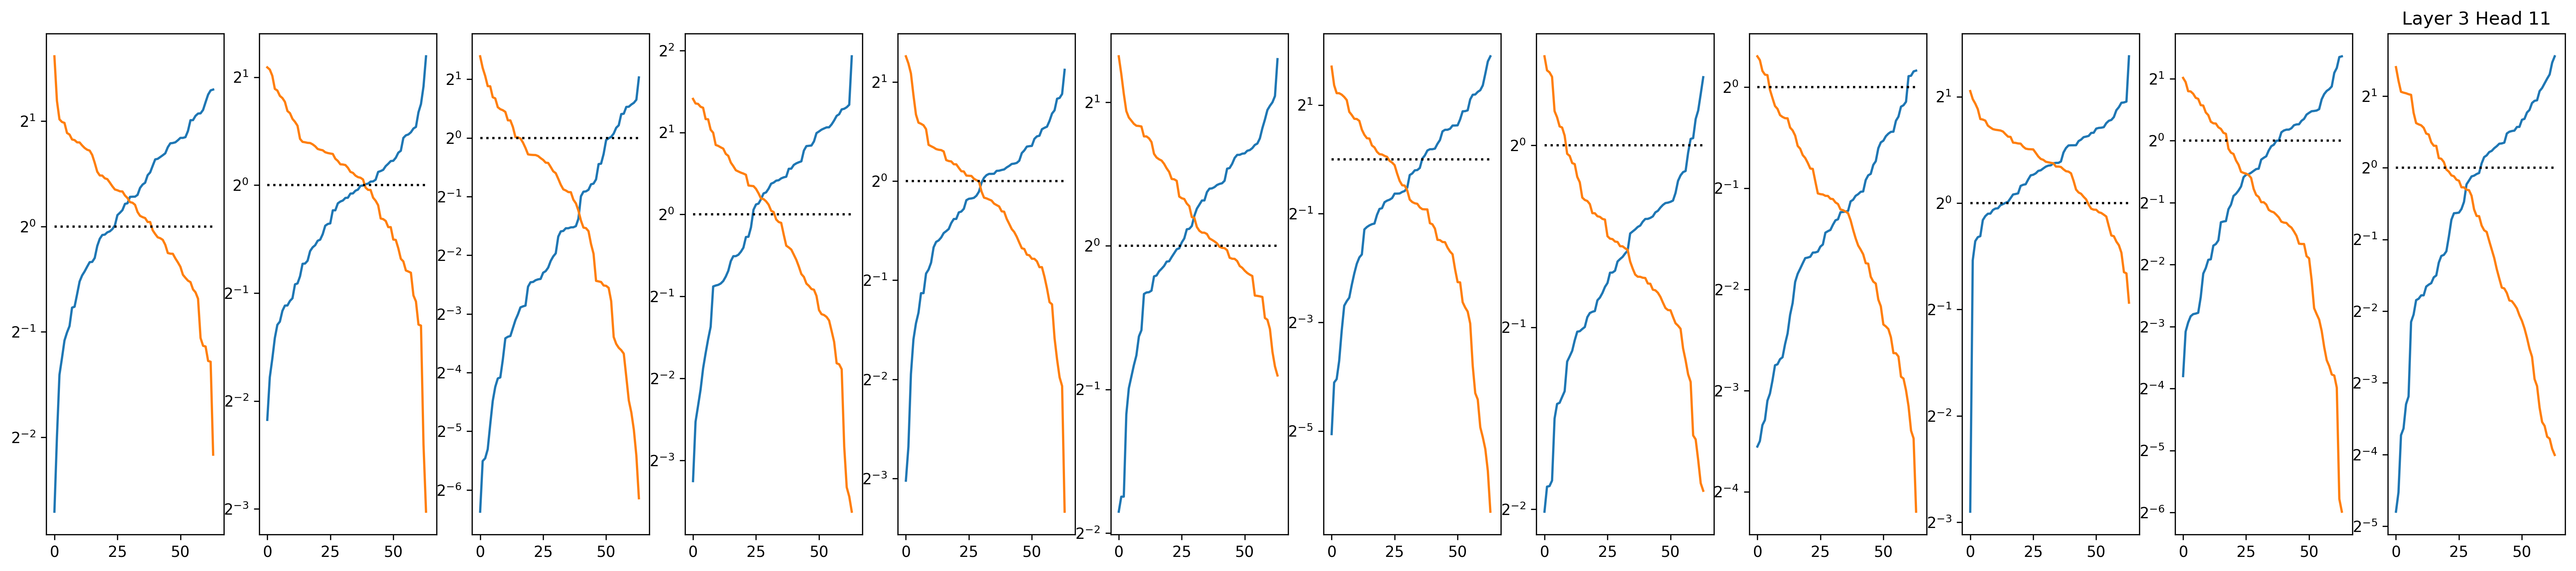

[False, False, False, False, False, False, True, False, False, False, True, False]


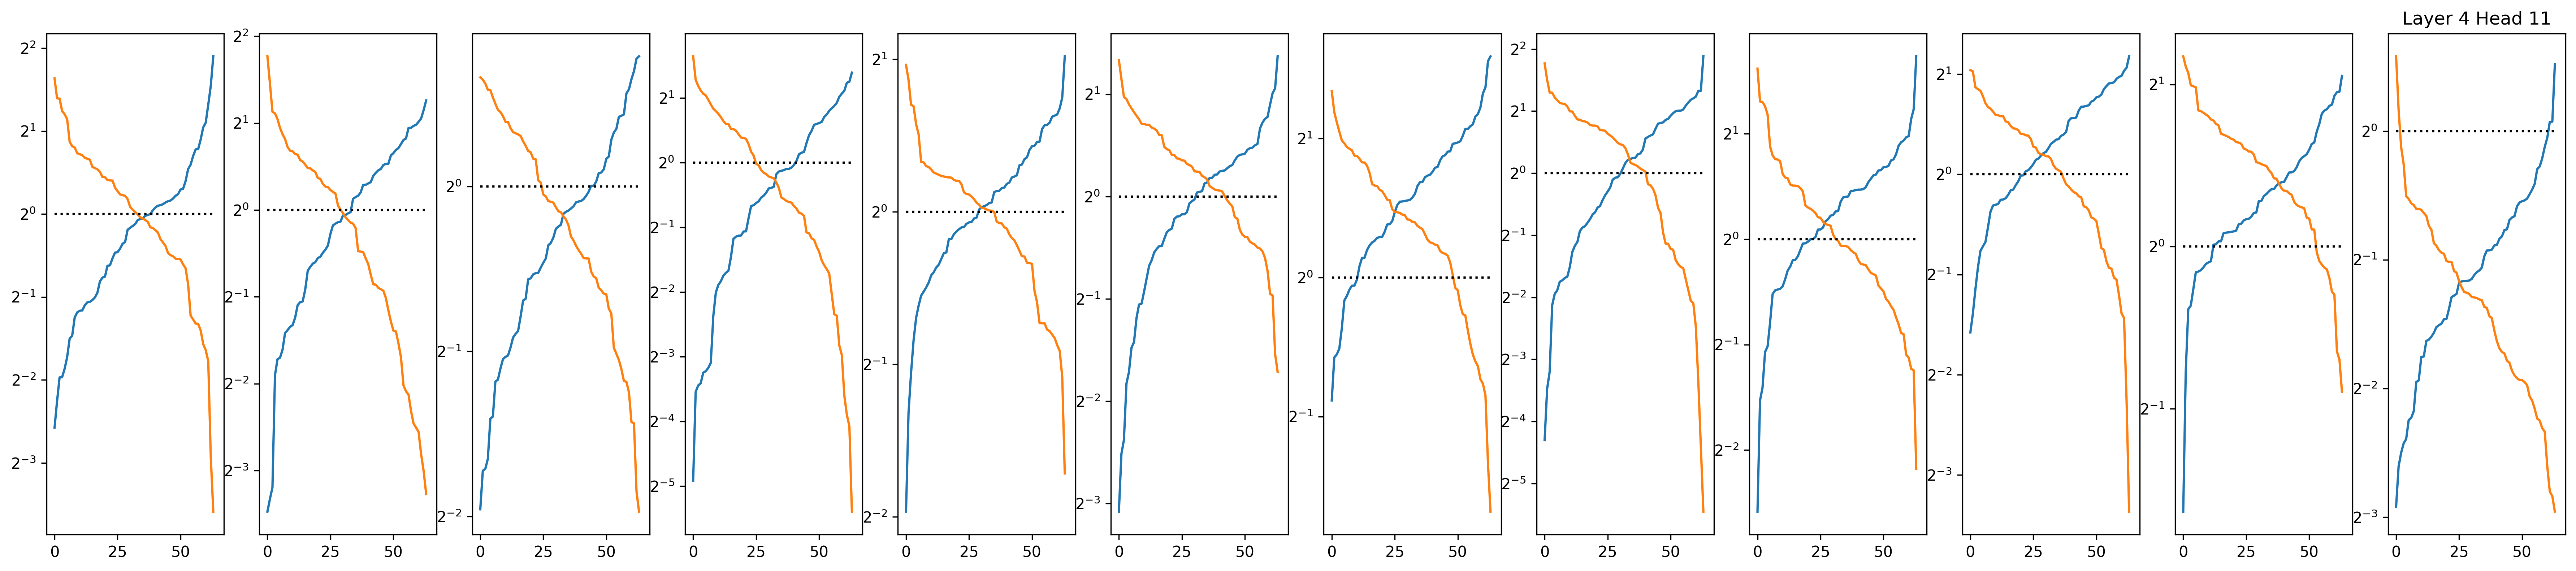

[False, True, True, False, False, False, False, False, False, False, False, False]


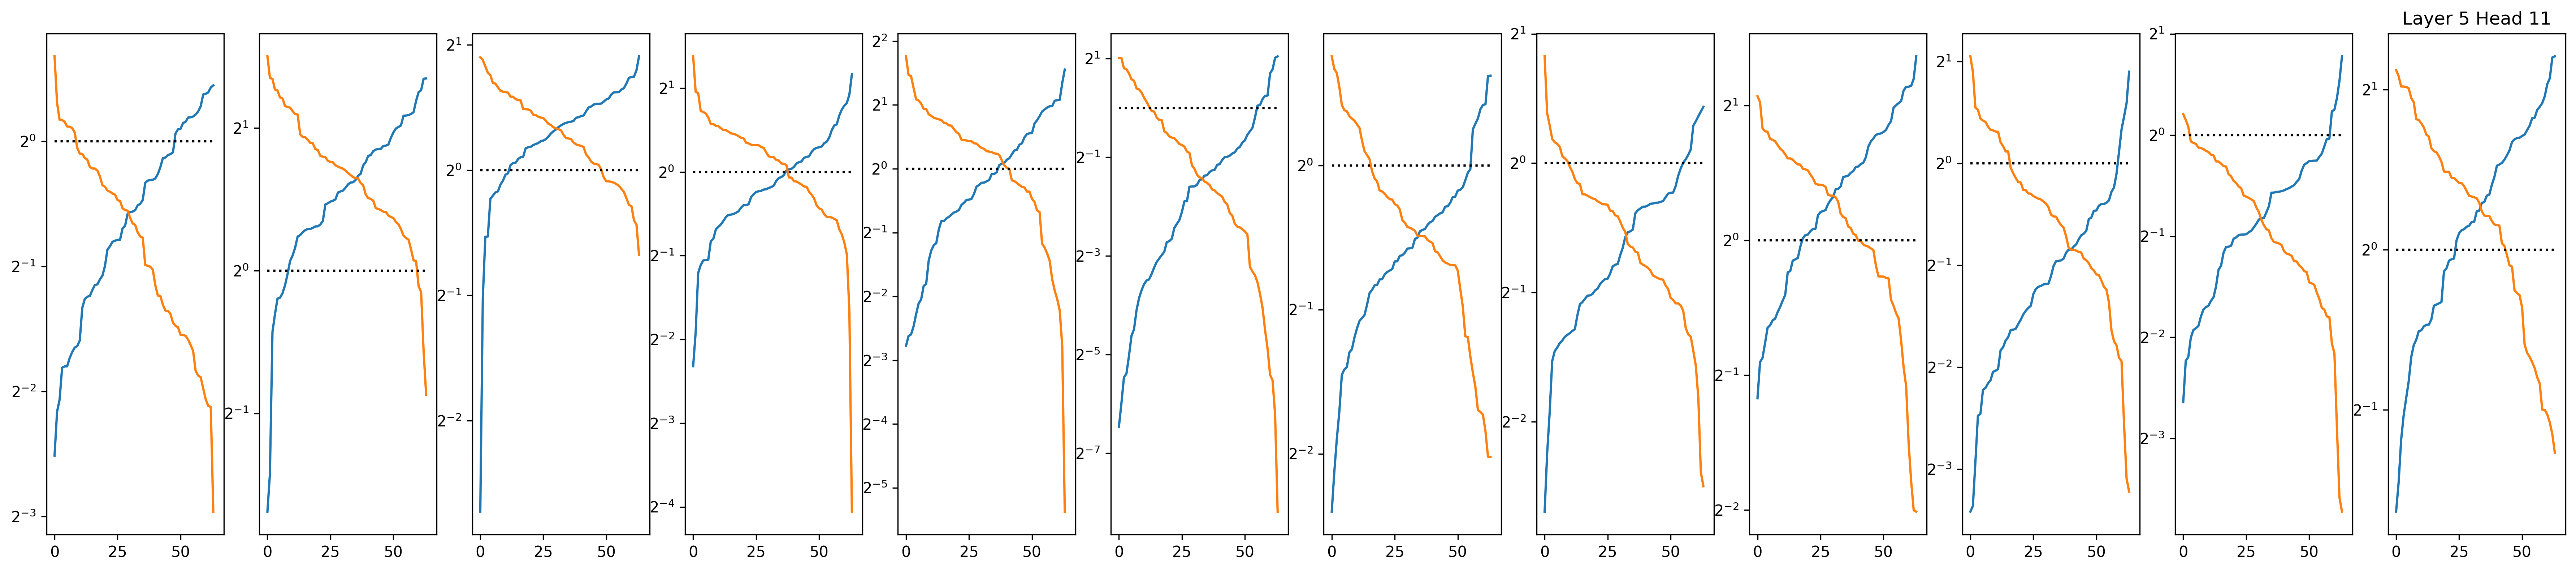

[True, False, False, False, False, False, False, False, False, False, False, False]


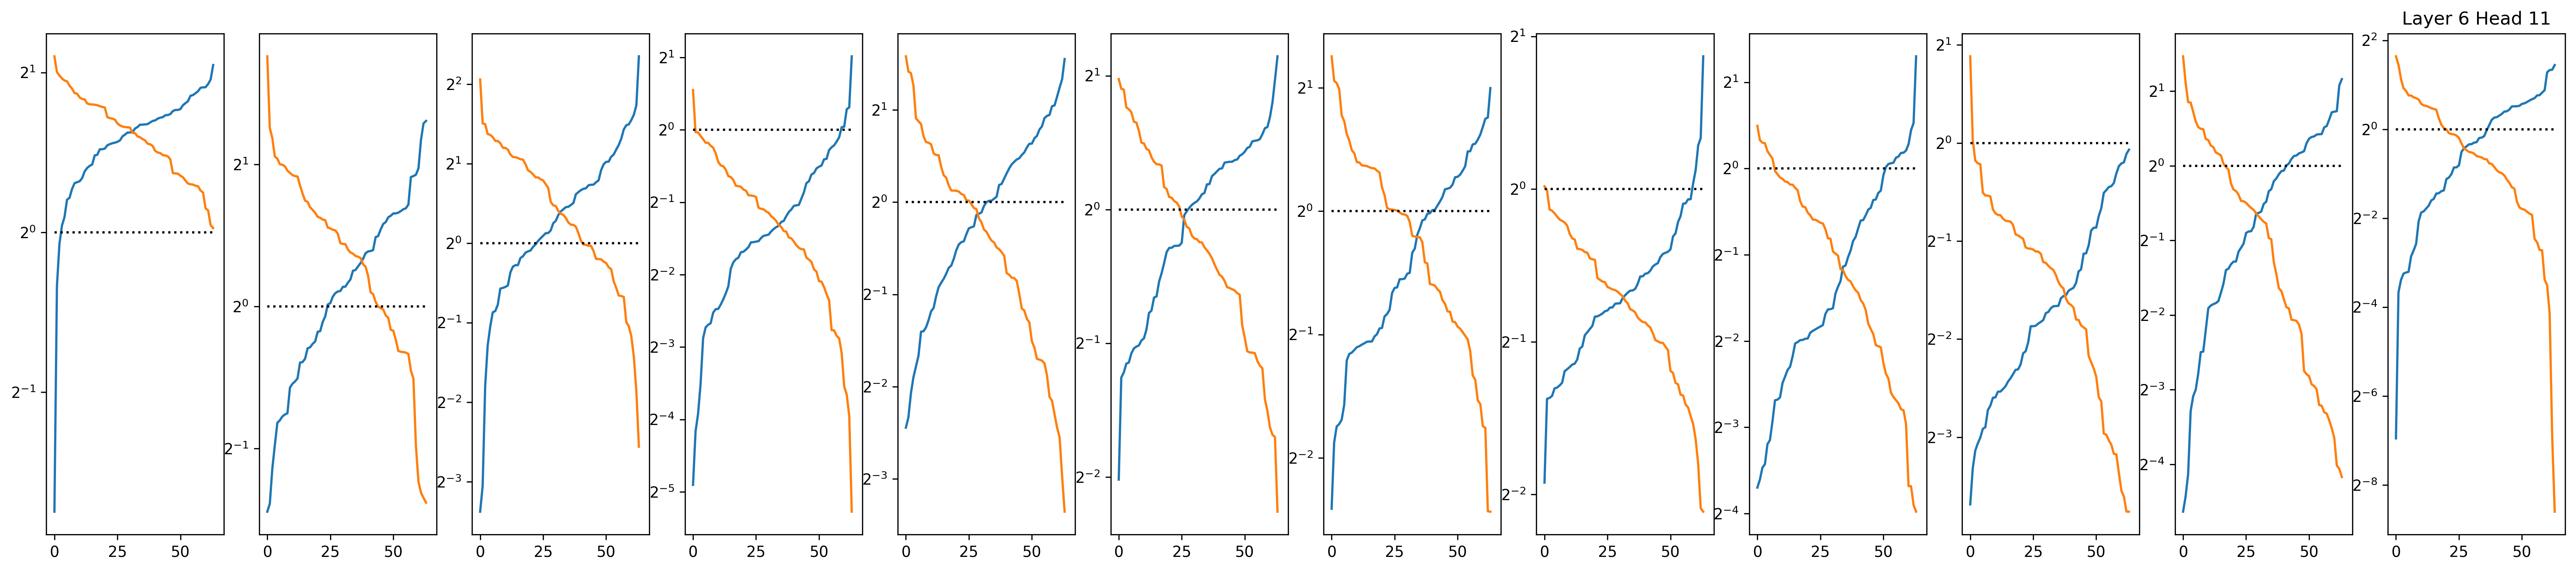

[True, False, False, False, False, True, False, False, False, False, False, False]


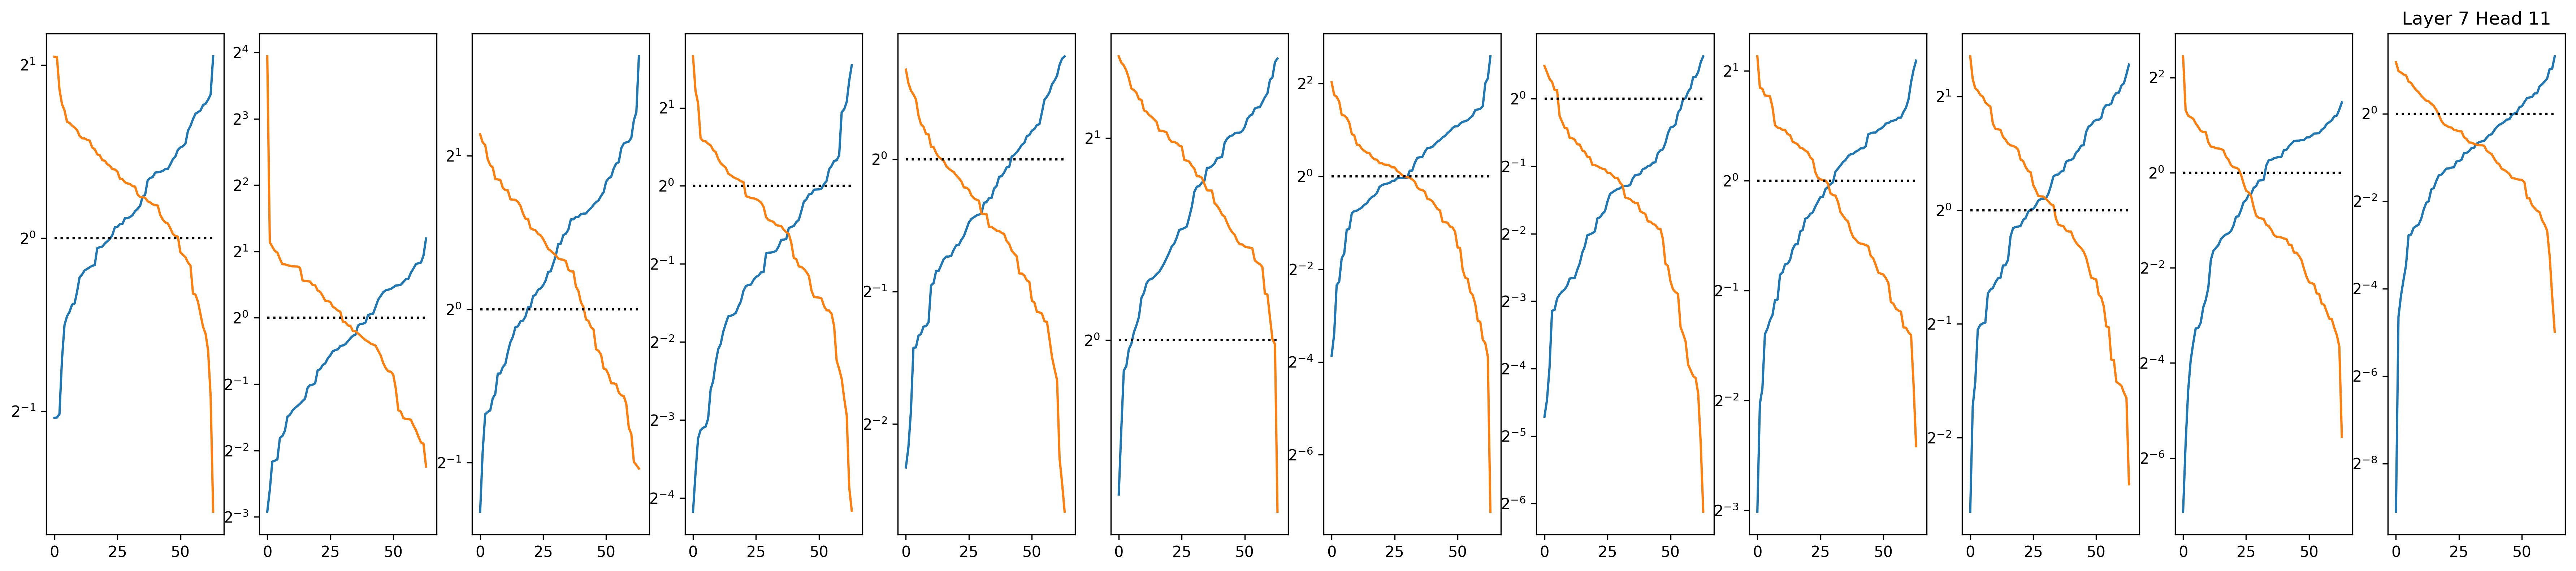

[True, False, False, False, True, True, False, False, False, False, False, False]


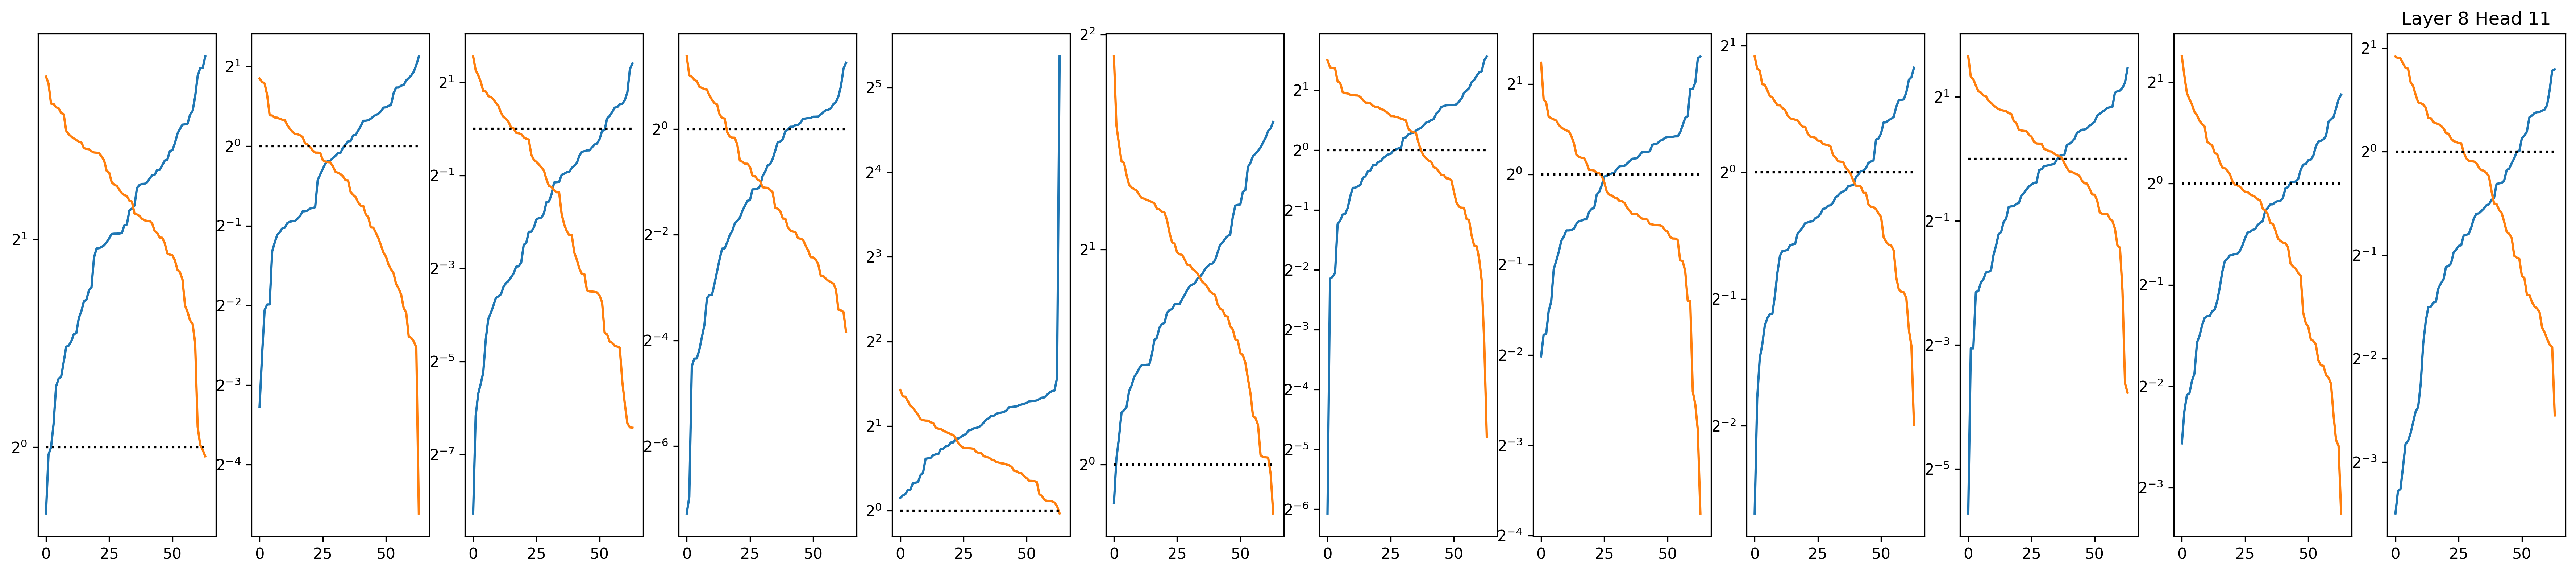

[False, False, True, False, False, False, False, True, False, True, False, True]


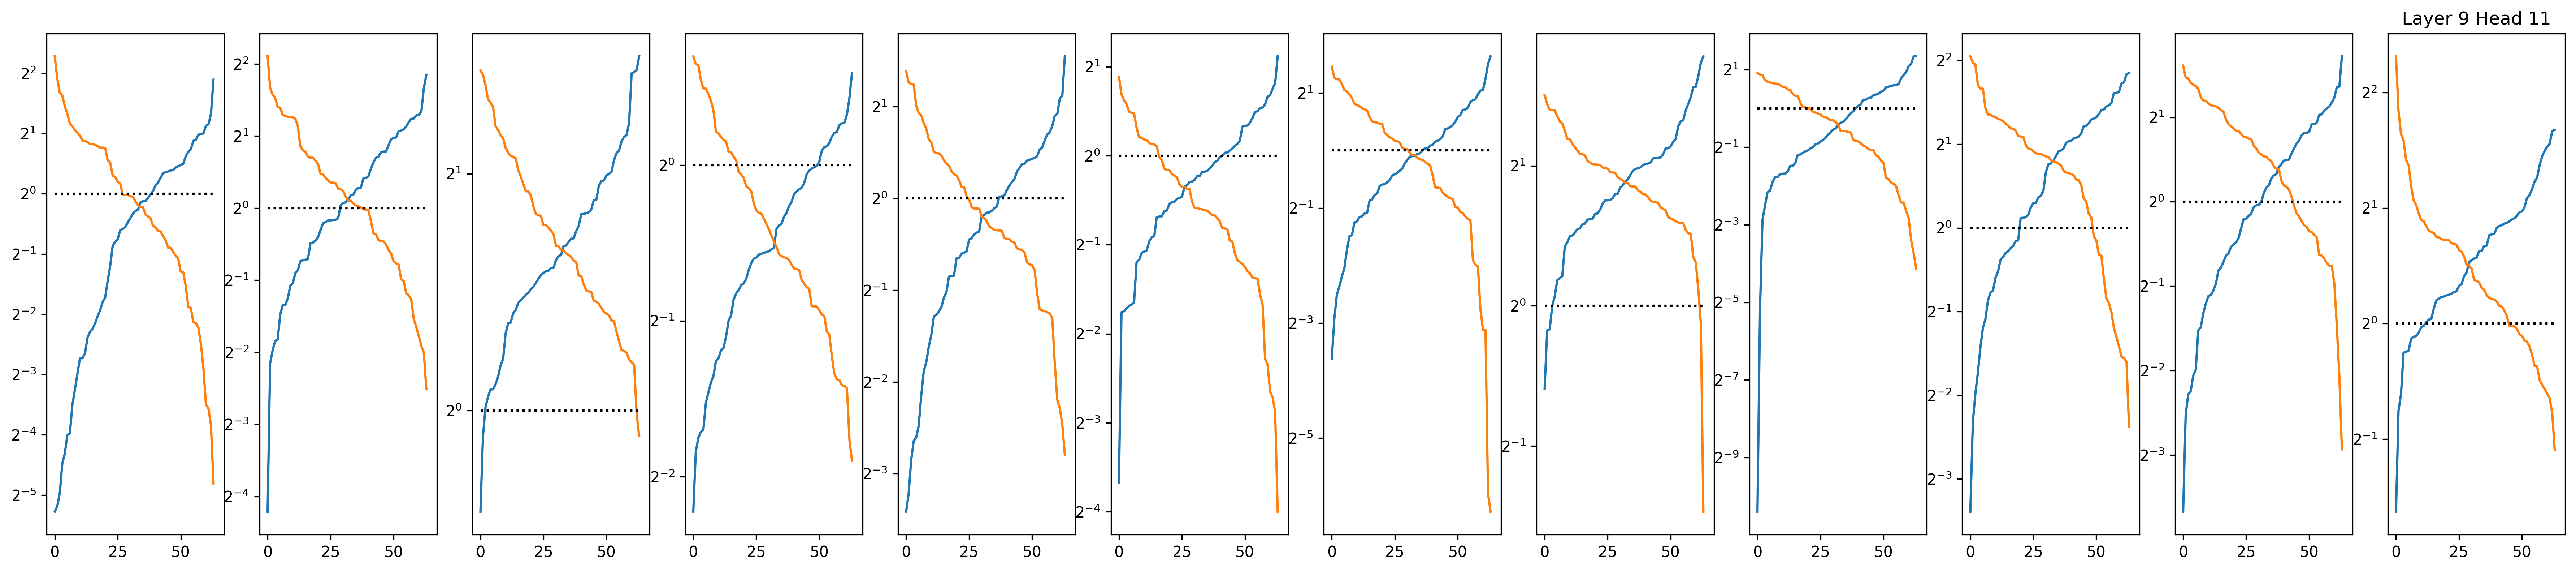

[False, False, False, False, False, False, False, False, False, False, False, False]


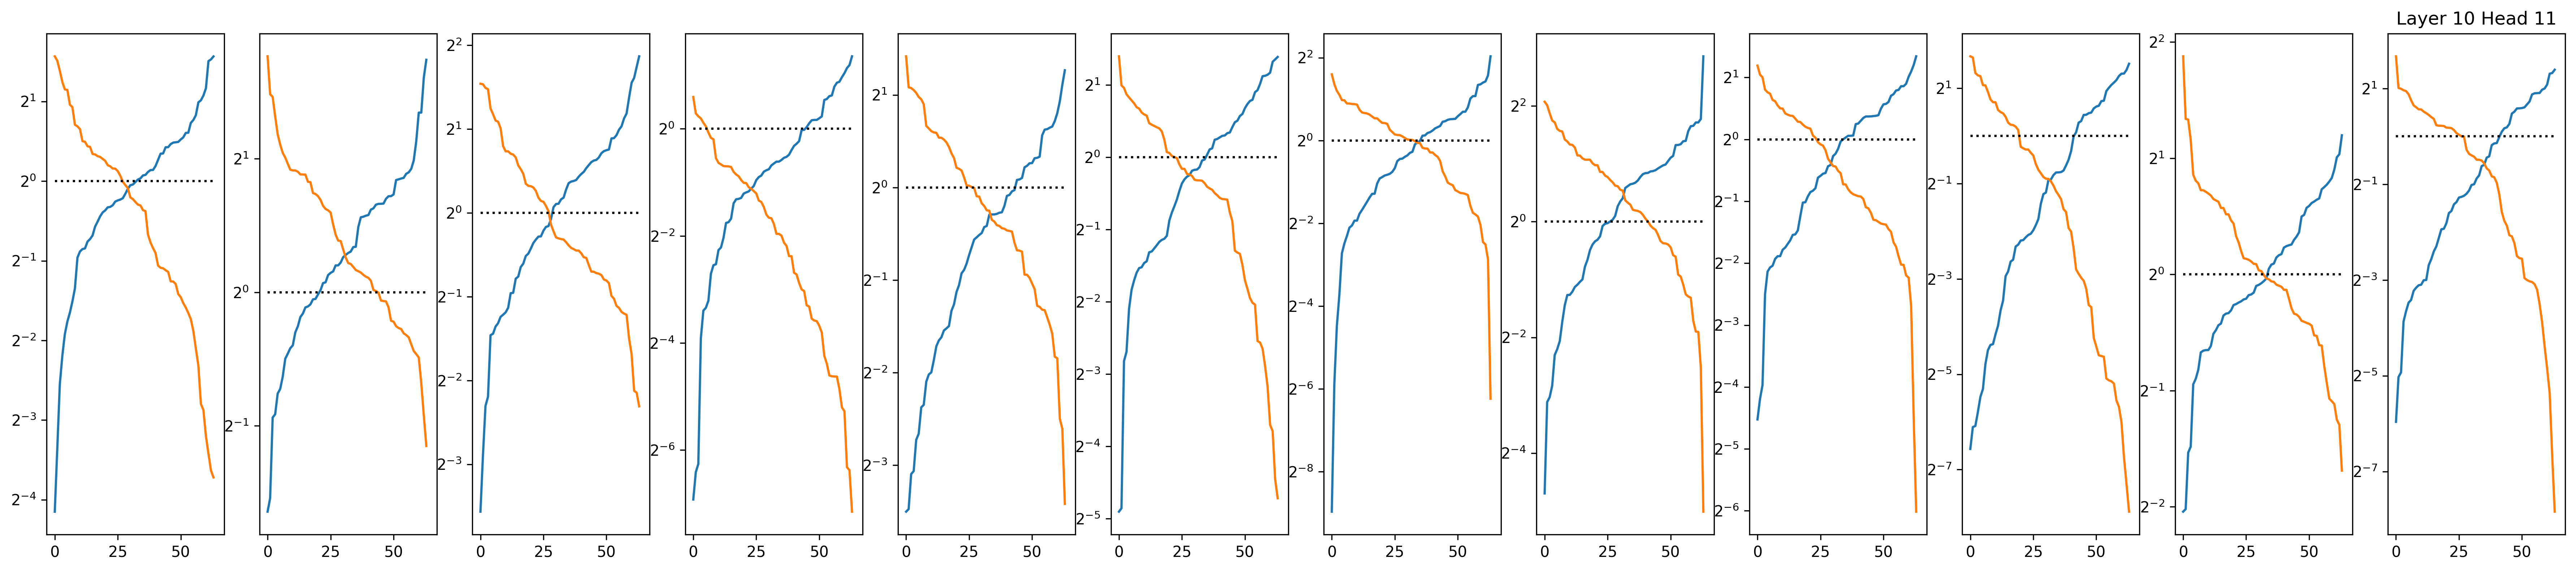

[False, False, False, False, False, False, False, False, False, False, False, False]


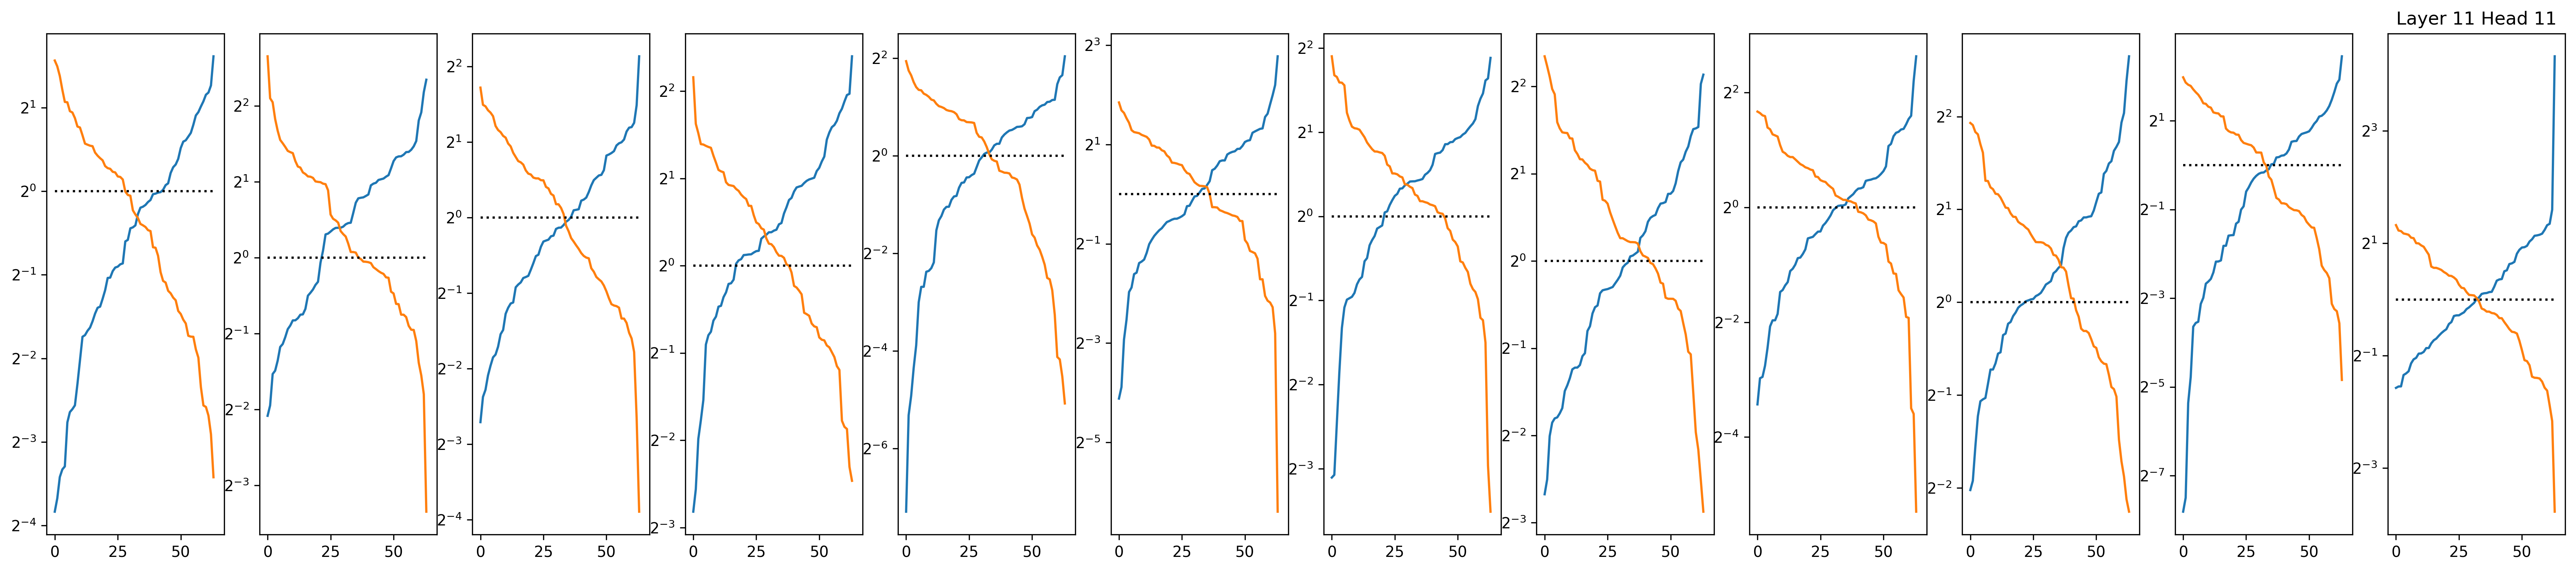

[[False, False, False, False, False, False, False, False, False, False, False, False], [False, False, False, False, False, False, False, False, False, False, False, False], [False, True, True, False, False, False, False, False, False, False, False, False], [False, False, False, False, False, False, False, False, False, True, False, False], [False, False, False, False, False, False, True, False, False, False, True, False], [False, True, True, False, False, False, False, False, False, False, False, False], [True, False, False, False, False, False, False, False, False, False, False, False], [True, False, False, False, False, True, False, False, False, False, False, False], [True, False, False, False, True, True, False, False, False, False, False, False], [False, False, True, False, False, False, False, True, False, True, False, True], [False, False, False, False, False, False, False, False, False, False, False, False], [False, False, False, False, False, False, False, False, False, False,

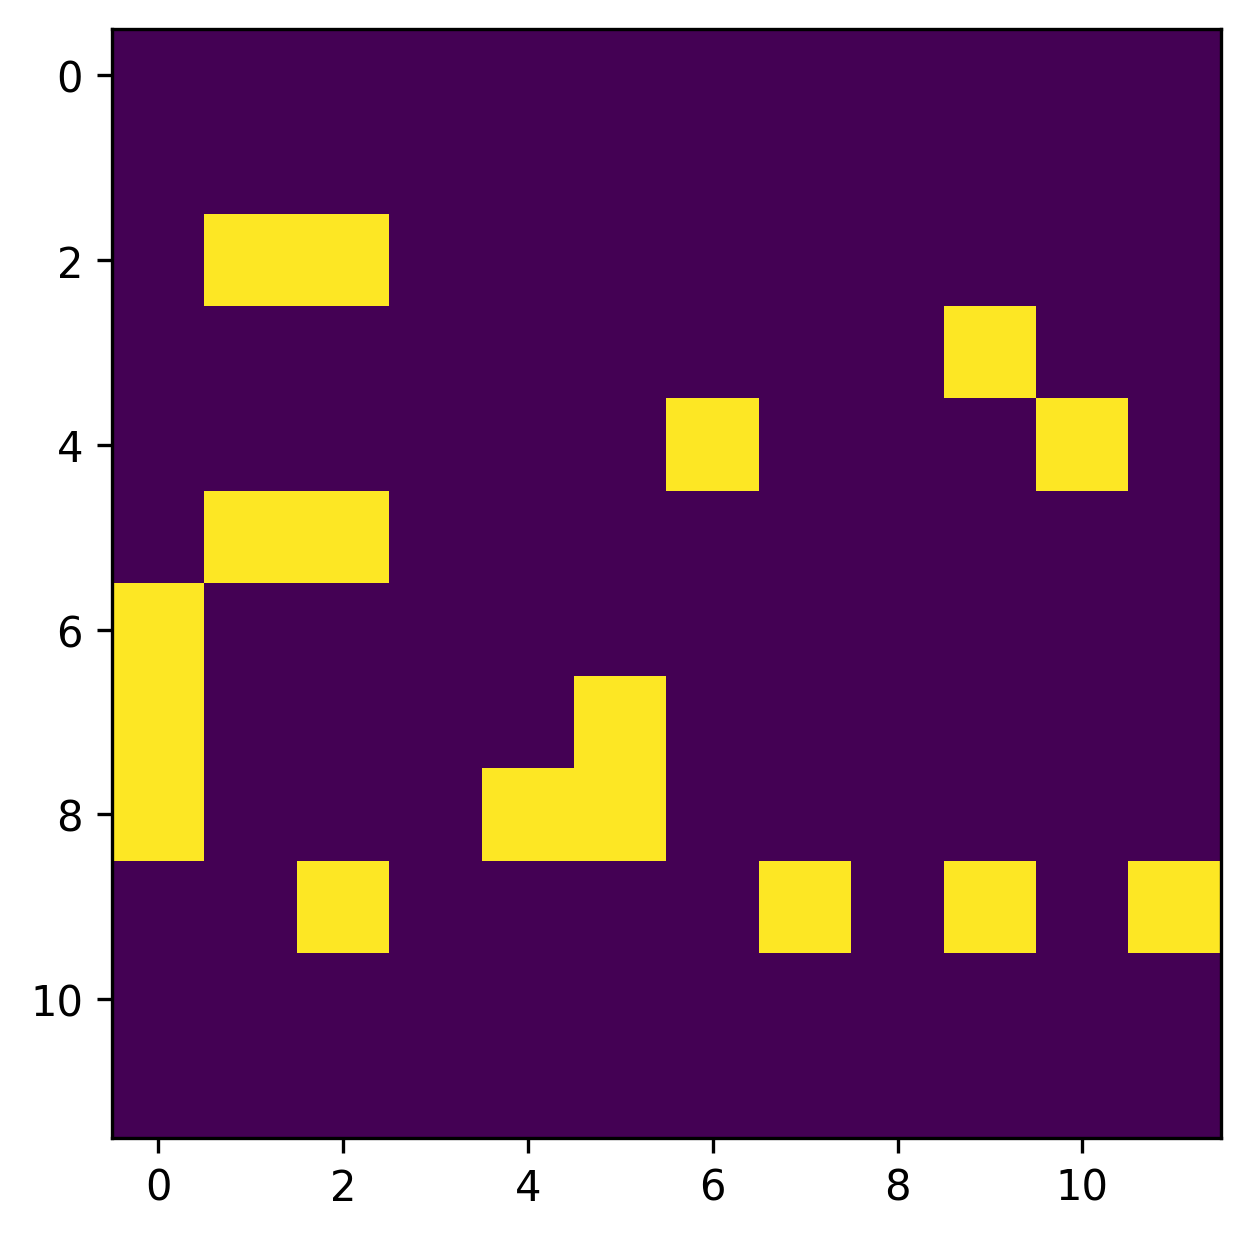

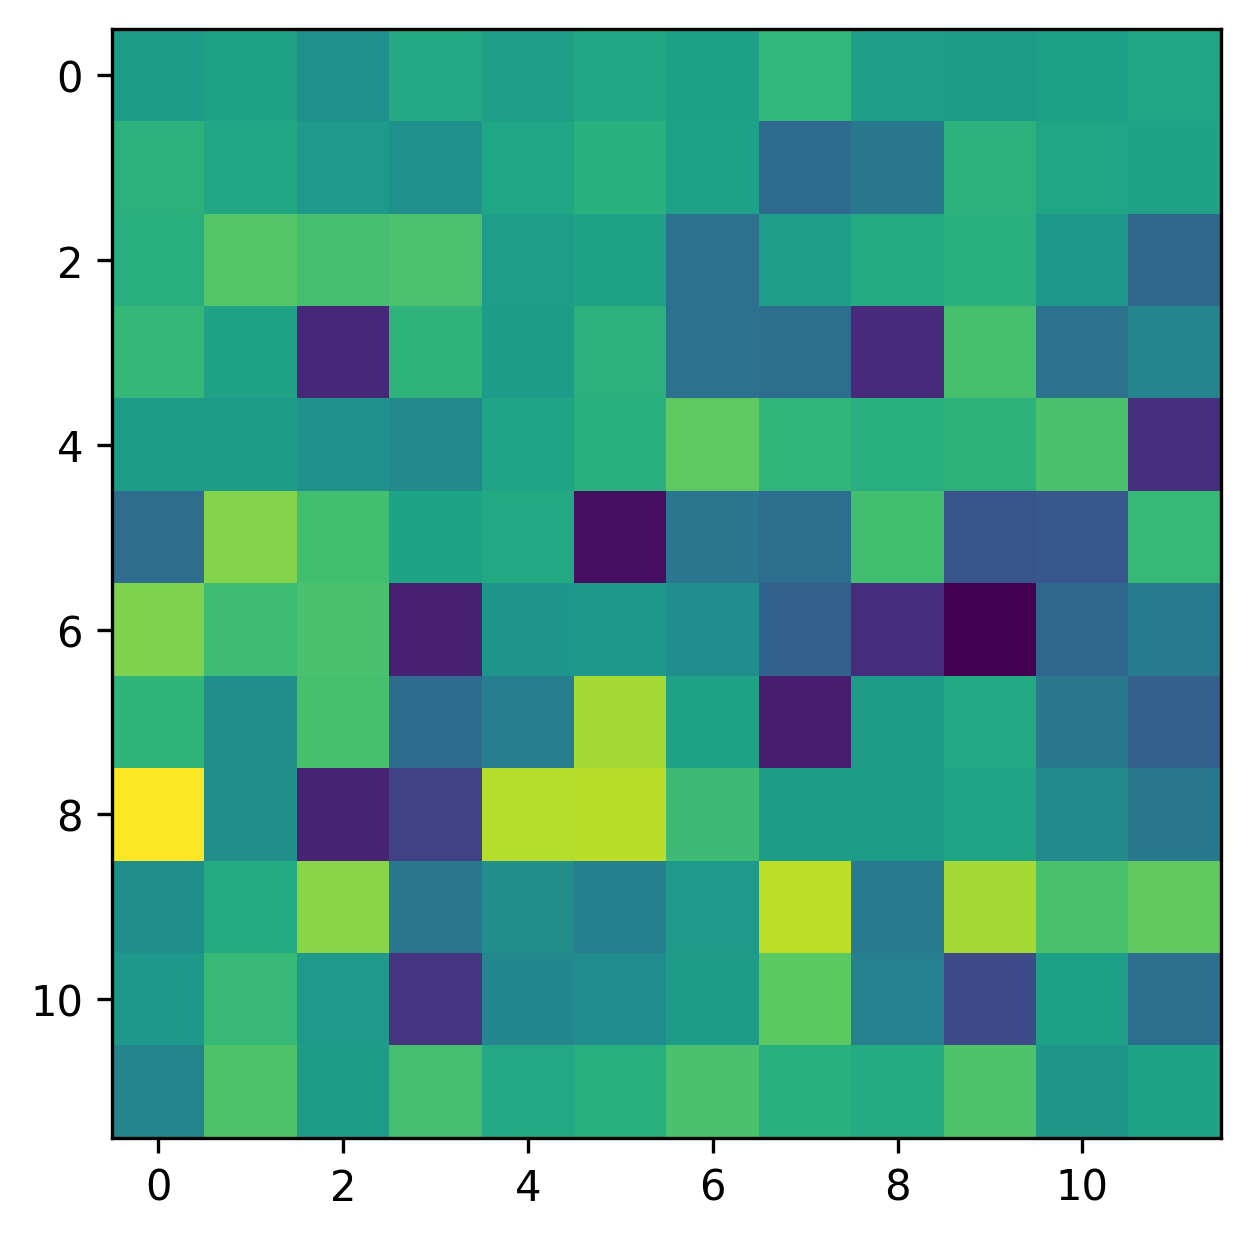

In [ ]:
from tracemalloc import Snapshot
from matplotlib.pyplot import plot
from torch import le

removals = []
crossover_multiple = []
for layer in range(12):
    removals.append([ False for _ in range(12)])
    crossover_multiple.append([ 1.0 for _ in range(opt.n_heads) ])

    fig, axes = plt.subplots(1, 12, figsize=(30,6))
    plt.title(f'Layer {layer} Head {head}')
    for head in range(12):
        ax = axes[head]

        curr_pile_pos = pile_pos[layer][head]
        curr_pile_neg = np.abs( pile_neg[layer][head] )
        curr_code_pos = code_pos[layer][head]
        curr_code_neg = np.abs( code_neg[layer][head] )

        pile_vs_code_rel_pos_freq = ( curr_code_pos + 1e-5 ) / ( curr_pile_pos + 1e-5 )
        pile_vs_code_rel_neg_freq = ( curr_code_neg + 1e-5 ) / ( curr_pile_neg + 1e-5 )
        pos_indx = np.sort( pile_vs_code_rel_pos_freq )
        neg_indx = np.sort( pile_vs_code_rel_neg_freq )[::-1]
        ax.semilogy( pos_indx, base=2 )
        ax.semilogy( neg_indx, base=2 )
        ax.hlines(y=1, xmin=0, xmax=len(curr_pile_pos), color='black', linestyle=':' )

        #cross-over position
        for i in range(opt.d_head):
            if pos_indx[i] > neg_indx[i]:
                break
        crossover =  ( pos_indx[i-1] + pos_indx[i] + neg_indx[i-1] + neg_indx[i] )/4
        crossover_multiple[layer][head] = crossover

        if pos_indx[16] > 1 or neg_indx[48] > 1:
            removals[-1][head] = True

    plt.show()

print( removals )
plt.figure()
plt.imshow(removals)
plt.show()
plt.figure()
plt.imshow( np.log(crossover_multiple) )
plt.show()


In [ ]:
from random import sample
from tqdm.notebook import tqdm
import os
import datetime

def setup_counter(ff_keys):
    shape = ff_keys.size()
    counter = []
    for i in range(shape[0]):
        counter.append( torch.zeros( shape[-1]))
    return torch.stack(counter).to( opt.device )

def count_keys( dataset_name, limit=1000, sample_size=10000, num_samples=1, 
                check_accuracy=False, k=10, check_skips=False ):
    dataset, label, skip_eval = prepare( dataset_name )
    counters = []
    counter = None
    curr_count = 0
    with tqdm(total=sample_size*num_samples) as pbar:
        for data in dataset:
            text = data[label]
            input_ids = opt.get_ids( text, limit=limit )
            ids = input_ids.squeeze().detach().cpu()

            # Criteria for counting the token activation
            criteria = torch.ones_like( ids, dtype=torch.bool )

            # check if prediction is accurate enough to count
            if check_accuracy:
                residual_stream = opt.get_residual_stream( input_ids=input_ids )
                logits = opt.unembed( residual_stream[-1] ).detach().cpu()
                top_k_tokens = opt.top_k_tokens( logits, k=k ).squeeze()

                for index in range(len(ids)-1):
                    criteria[index] *= (ids[index+1] in top_k_tokens[index])

            # Choose a set of token ids to skip 
            if check_skips:
                skip_ids = set()
                for skip_string in skip_eval:
                    skip_id = int( opt.get_ids( skip_string ).squeeze()[-1] )
                    skip_ids.add( skip_id )

                for index in range(len(ids)-1):
                    criteria[index] *= (ids[index+1] in skip_ids)
                
            num_valid_tokens = criteria.sum()
            curr_count += num_valid_tokens

            ff_keys = opt.get_ff_key_activations(input_ids=input_ids)
            if counter is None:
                counter = setup_counter(ff_keys)
            
            for layer_index, layer in enumerate(ff_keys):
                for token_index, key_activation in enumerate(layer):
                    if not criteria[token_index]:
                        continue
                    counter[layer_index] += ( key_activation != 0 )


            pbar.update( int(num_valid_tokens) )
            if curr_count > sample_size:
                counter = counter / curr_count
                counters.append( counter.detach().cpu() )
                print( f'sample {len(counters)}: {curr_count}' )
                
                counter = setup_counter(ff_keys)
                curr_count = 0
            
            if len( counters ) >= num_samples:
                break
    
    return torch.stack( counters )

def acc_str( acc, pred ):
    percentage = (100*round(acc/pred, 3))
    return "%.1f"%percentage + "% - ( {acc}/{pred} )"

def evaluate( dataset_name, limit : int = 1e6, topk: int = 1 ):
    dataset, label, skip_eval = prepare( dataset_name )
    out = opt.evaluate_dataset( dataset, token_limit=1000, k=topk,
        start_index=1, stopping_index=limit, skip_eval=skip_eval,
        dataset_text_label=label, count_tokens=False )
    print( f'{dataset_name} w/ skip:', 
        acc_str(out['num_skip_accurate'], out['num_skip_predictions']) )
    print( f'{dataset_name} no skip:',
        acc_str( out['num_accurate'], out['num_predictions']) )
    return out

def evaluate_all( limit: int = 1e5, topk: int = 1 ):
    pile_out = evaluate( 'pile', limit, topk )
    code_out = evaluate( 'code', limit, topk )
    percentages = {
        "pile_skip": 100*pile_out['num_skip_accurate']/pile_out['num_skip_predictions'],
        "pile": 100*pile_out['num_accurate']/pile_out['num_predictions'],
        "code_skip": 100*code_out['num_skip_accurate']/code_out['num_skip_predictions'],
        "code": 100*code_out['num_accurate']/code_out['num_predictions'],
    }
    return percentages

def save_numpy( array, name ):
    filename = f'tmp/{opt.model_size}-{freq_multiple}x-{name}.npy'
    os.makedirs( 'tmp', exist_ok=True )
    with open(filename, 'wb') as f:
        np.save(f, np.array(array) )
    print("saved successfully")

def delete_and_evaluate(
        freq_multiple: float,
        counter_sample_size: int = 5e4,
        eval_sample_size: int = 1e5,
        ):
    # Count activation of MLP middle layers
    pile_counters = count_keys( 'pile', sample_size=counter_sample_size, num_samples=1, check_accuracy=True )
    code_counters = count_keys( 'code', sample_size=counter_sample_size, num_samples=1, check_accuracy=True )
    
    # Delete when the MLP layer activates way more for code than pile
    ff_criterion = ( code_counters[0] > (freq_multiple*pile_counters[0]) )
    sums = [ x.sum() for x in ff_criterion.detach().numpy() ]
    num_removed = np.sum(sums)
    print( "%5d -"%num_removed, sums )
    opt.delete_ff_keys( ff_criterion )
    
    try:
        # Save the indices that were deleted into the timestamped file
        print("saving files...")
        now = datetime.datetime.now().strftime( "%Y-%m-%d_%H:%M:%S" )
        save_numpy( ff_criterion,     f'criterion_{now}' )
        save_numpy( pile_counters[0], f'counters-pile_{now}' )
        save_numpy( code_counters[0], f'counters-code_{now}' )
        
    except Exception:
        print("Did not save sadly :(")

    
    # See the effect this has on performance
    data = evaluate_all( eval_sample_size )
    data['removed'] = num_removed
    return data

In [ ]:
pre_removals = []

criteria = None

for filename in pre_removals:
    ff_criterion = np.load(filename)
    if criteria is None:
        criteria = np.zeros_like( ff_criterion )
    criteria += ff_criterion

    sums = [ x.sum() for x in ff_criterion ]
    print( "%5d -"%np.sum(sums), sums )
    #opt.delete_ff_keys( ff_criterion )

criteria = 1 - criteria
sums = [ x.sum() for x in criteria ]
print( np.sum(sums), sums )
opt.delete_ff_keys(  criteria )

TypeError: unsupported operand type(s) for -: 'int' and 'NoneType'

In [ ]:
df = pd.DataFrame()

# Evaluate model before removal of any neurons
data = evaluate_all( 1e5, topk=10 )
df = df.append( data, ignore_index=True )
print( df.T )

In [ ]:
FREQ_MULTIPLE = 3.2

for i in range(4):
    print('\n\n- RUNNING RUN No', i )
    data = delete_and_evaluate( FREQ_MULTIPLE )
    df = df.append( data, ignore_index=True )
    print( df.T )

In [ ]:
for i in range(4):
    print('\n\n- RUNNING RUN No', i )
    data = delete_and_evaluate( FREQ_MULTIPLE )
    df = df.append( data, ignore_index=True )
    print( df.T )

In [ ]:
for i in range(4):
    print('\n\n- RUNNING RUN No', i )
    data = delete_and_evaluate( FREQ_MULTIPLE )
    df = df.append( data, ignore_index=True )
    print( df.T )